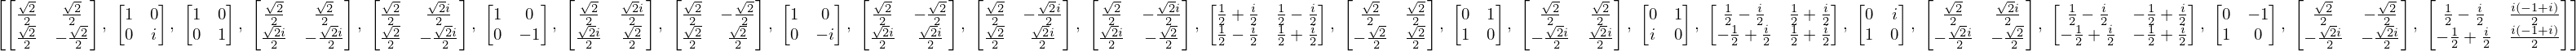

In [1]:
import sympy
import numpy as np

M = sympy.Matrix
simplify = sympy.simplify
sqrt = sympy.sqrt
i = sympy.I
_i = i

from sympy.physics.quantum import Dagger
from sympy.physics.quantum import tensorproduct

sympy.init_printing()
H = simplify(M([[1, 1], [1, -1]]) / sqrt(2))
S = M([[1, 0], [0, i]])
C_L = [H, S]
basis_vectors = [M([1, 0]), M([0, 1])]

def getitem(m, i, j):
    # Note that sympy uses an extremely weird way to store the matrices,
    # in particular the internal representation is vastly different from what
    # is printed. For instance the H matrix is stored as a Mul object
    # (even after using simplify) instead of a matrix. 
    # Therefore m[i][j] will NOT work. This is a workaround.
    return (Dagger(basis_vectors[i]) * m * basis_vectors[j])[0]

def is_known(C_L, a):
    for c in C_L:
        test = c * Dagger(a)
        if(simplify(getitem(test, 0, 1)) != 0):
            continue
        if(simplify(getitem(test, 0, 0) / getitem(test, 1, 1)) == 1):
            return True
    return False
for i in range(5):
    for m in (H, S):
        for c in C_L:
            c = simplify(c*m)
            if(is_known(C_L, c)):
                continue
            C_L.append(c)
C_L

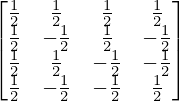

In [2]:
H2 = tensorproduct.matrix_tensor_product(H, H)
H2

In [3]:
zero_state = M([1, 0, 0, 0])

In [4]:
plus_state = H2 * zero_state
plus_state

In [5]:
I = M([[1, 0], [0, 1]])

In [6]:
C_L_0 = [tensorproduct.matrix_tensor_product(I, c) for c in C_L]

In [7]:
C_L_1 = [tensorproduct.matrix_tensor_product(c, I) for c in C_L]

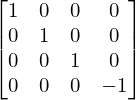

In [8]:
CZ = M([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]])
CZ

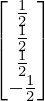

In [9]:
CZ * plus_state

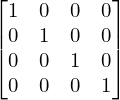

In [10]:
I_4 = M([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
I_4

In [11]:
from itertools import product
starting_states = [ c0 * c1 * ent * plus_state for ent, c0, c1 in product((I_4, CZ), C_L_0, C_L_1)]


In [12]:
len(starting_states) == 2 * 24**2

True

In [13]:
resulting_states = [CZ * s for s in starting_states]

In [14]:
starting_states_np = [np.array(s).astype(np.cdouble)[:, 0] for s in starting_states]
resulting_states_np = [np.array(s).astype(np.cdouble)[:, 0] for s in resulting_states]

In [15]:
from collections import defaultdict

In [16]:
state_indices = defaultdict(list)

for rs_np in resulting_states_np:
    for j, ss_np in enumerate(starting_states_np):
        c = ss_np.transpose().conjugate().dot(rs_np)
        if(c * c.conjugate() == 1):
            state_indices[tuple(rs_np)].append(i)


In [17]:
missing = []
for rs, rs_np in zip(resulting_states, resulting_states_np):
    if(not tuple(rs_np) in state_indices
          or state_indices[tuple(rs_np)] == []):
        missing.append(rs)
len(missing)

In [18]:
len(missing) / 24 

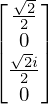

In [19]:
missing[0]

In [46]:
starting_matrices = [a * b * c for a, b, c in product(C_L_0, C_L_1, (I_4, CZ))]

In [47]:
resulting_matrices = [CZ * c for c in starting_matrices]

In [49]:
starting_matrices_np = np.array([np.array(m).astype(np.cdouble) for m in starting_matrices])

starting_matrices_np.shape

In [50]:
resulting_matrices_np = np.array([np.array(m).astype(np.cdouble) for m in resulting_matrices])

resulting_matrices_np.shape

In [51]:
resulting_matrices_np_invers = np.array([m.transpose().conjugate() for m in resulting_matrices_np])

In [52]:
indices = defaultdict(list)

for rm_np, rm_np_i in zip(resulting_matrices_np, resulting_matrices_np_invers):
    for i, sm_np in enumerate(starting_matrices_np):
        test = sm_np.dot(rm_np_i)
        check_indices_zero = [(1,2), (1,3), (1,4), (2,3), (2,4), (3,4)]
        check_indices_zero += [(k,i) for i,k in check_indices_zero]
        check_indices_zero = [(i - 1, k - 1) for i, k in check_indices_zero]
        for check in check_indices_zero:
            if(not np.allclose(test[check], 0)):
                continue

        diag = np.diagonal(test)
        phases = np.angle(diag)
        phases = phases - phases[0]
        if(not np.allclose(phases, np.zeros(4))):
            continue
        indices[tuple((tuple(r) for r in rm_np))].append(i)
        
len(indices.keys())

In [54]:
indices[tuple(((tuple(r) for r in resulting_matrices_np[0])))]

In [56]:
indices[tuple(((tuple(r) for r in resulting_matrices_np[1])))]

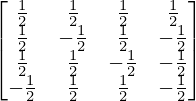

In [55]:
resulting_matrices[0]

In [60]:
from collections import deque
lookup_edge_c0_c1_to_number = []
r = []
c = []

i = 0

for _ in C_L_0:
    r = []
    for _ in C_L_1:
        c = []
        for _ in (I_4, CZ):
            c.append(i)
            i += 1          
        r.append(c)
    lookup_edge_c0_c1_to_number.append(r)
    
lookup_edge_c0_c1_to_number = np.array(lookup_edge_c0_c1_to_number, dtype=np.int)
lookup_edge_c0_c1_to_number.shape

In [ ]:
indices_contracted = {k: contract_indices(v) for k,v in indices.items()}

In [64]:
print("{")
for r in lookup_edge_c0_c1_to_number:
    print("    , {", ", ".join(("{%d, %d}" % (c[0], c[1]) for c in r)), "}")
print("}")    

{
    , { {0, 1}, {2, 3}, {4, 5}, {6, 7}, {8, 9}, {10, 11}, {12, 13}, {14, 15}, {16, 17}, {18, 19}, {20, 21}, {22, 23}, {24, 25}, {26, 27}, {28, 29}, {30, 31}, {32, 33}, {34, 35}, {36, 37}, {38, 39}, {40, 41}, {42, 43}, {44, 45}, {46, 47} }
    , { {48, 49}, {50, 51}, {52, 53}, {54, 55}, {56, 57}, {58, 59}, {60, 61}, {62, 63}, {64, 65}, {66, 67}, {68, 69}, {70, 71}, {72, 73}, {74, 75}, {76, 77}, {78, 79}, {80, 81}, {82, 83}, {84, 85}, {86, 87}, {88, 89}, {90, 91}, {92, 93}, {94, 95} }
    , { {96, 97}, {98, 99}, {100, 101}, {102, 103}, {104, 105}, {106, 107}, {108, 109}, {110, 111}, {112, 113}, {114, 115}, {116, 117}, {118, 119}, {120, 121}, {122, 123}, {124, 125}, {126, 127}, {128, 129}, {130, 131}, {132, 133}, {134, 135}, {136, 137}, {138, 139}, {140, 141}, {142, 143} }
    , { {144, 145}, {146, 147}, {148, 149}, {150, 151}, {152, 153}, {154, 155}, {156, 157}, {158, 159}, {160, 161}, {162, 163}, {164, 165}, {166, 167}, {168, 169}, {170, 171}, {172, 173}, {174, 175}, {176, 177}, {178,

In [68]:
I0_indices = lookup_edge_c0_c1_to_number[2, :, :].reshape(2*24)
I0_indices

array([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143])

In [69]:
I1_indices = lookup_edge_c0_c1_to_number[:, 2, :].reshape(2*24)
I1_indices

array([   4,    5,   52,   53,  100,  101,  148,  149,  196,  197,  244,
        245,  292,  293,  340,  341,  388,  389,  436,  437,  484,  485,
        532,  533,  580,  581,  628,  629,  676,  677,  724,  725,  772,
        773,  820,  821,  868,  869,  916,  917,  964,  965, 1012, 1013,
       1060, 1061, 1108, 1109])